# Calibration Script

**The results of this script for different filmtypes and channels are stored in /calibration to be used in the DoseMeasurementScript**

In [44]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import cv2
import os

### Film Type & Color Channel

In [45]:
filmtype = "EBT4"  #Choose EBT3 or EBT4
channel = "G"     #Choose G or RGB

### 1. Calibration Films - Intensity extraction

  Mean intensity square :  97.03513095238095


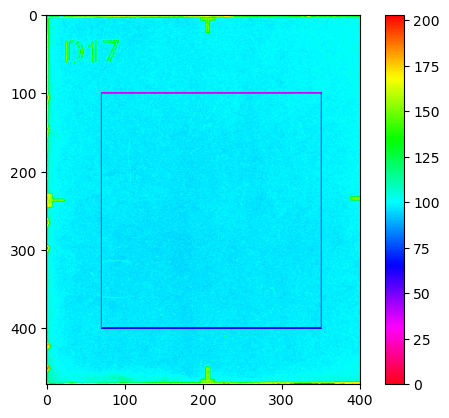

  Mean intensity square :  100.0364880952381


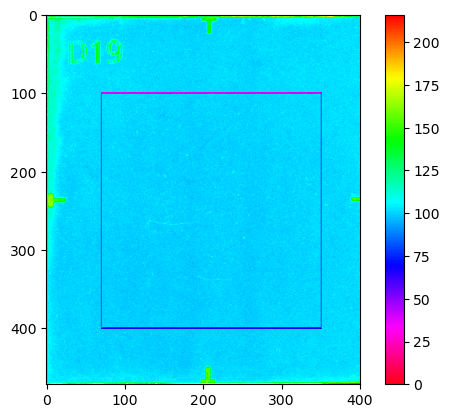

  Mean intensity square :  113.75864285714286


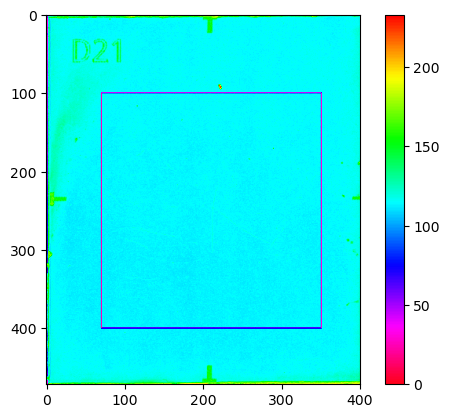

  Mean intensity square :  139.92220238095237


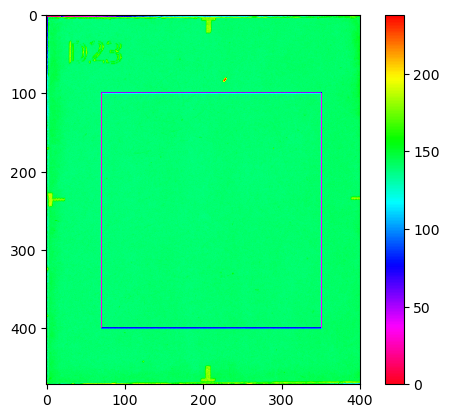

  Mean intensity square :  157.4950357142857


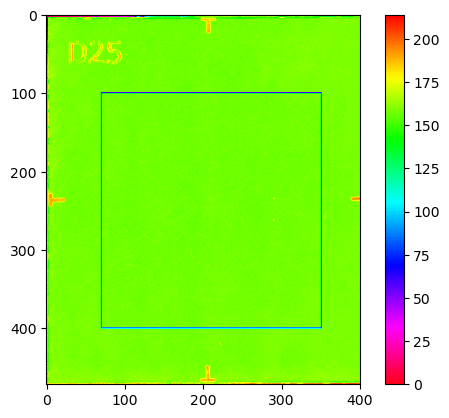

  Mean intensity square :  175.16083333333333


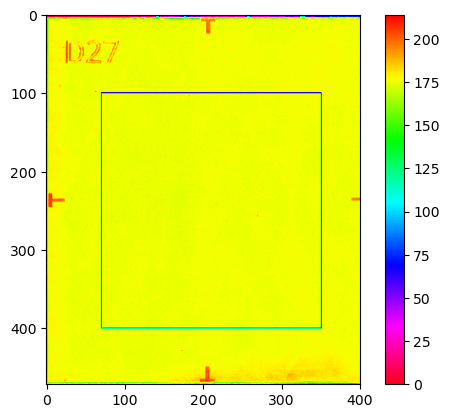

  Mean intensity square :  182.5592619047619


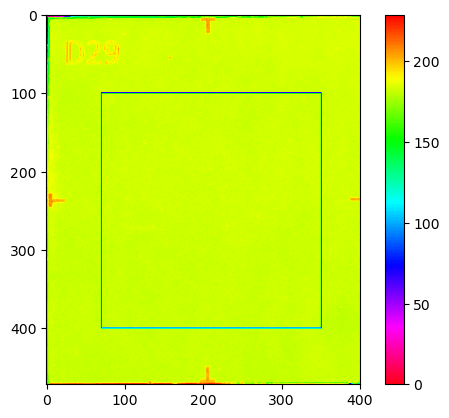

  Mean intensity square :  198.06016666666667


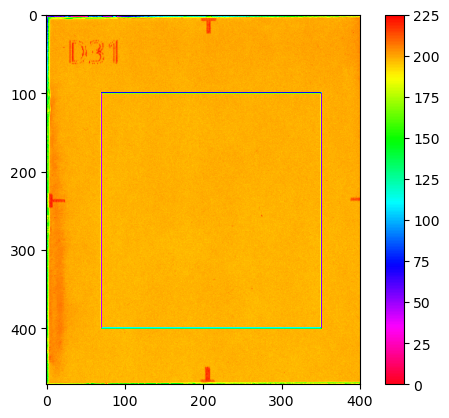

  Mean intensity square :  208.4497738095238


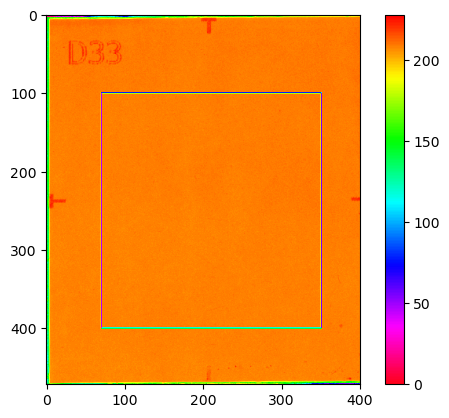

  Mean intensity square :  94.36064285714286


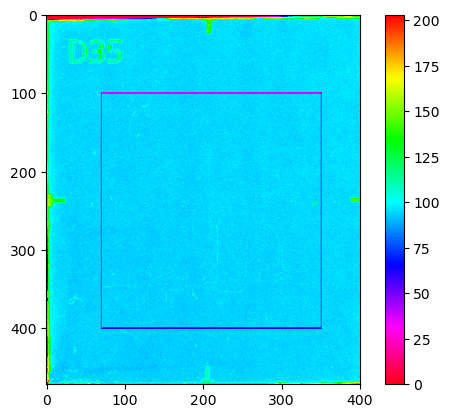

In [46]:
filenames = np.sort(os.listdir(f"calibration/{filmtype}"))

I=[]
n=0

with open(f"calibration/{filmtype}_int_{channel}.txt", "w") as text_file:                   
    text_file.write("Film \t Intensity\n")                                           
    
    for i in filenames:                                                                     
        file = f'calibration/{filmtype}/{i}'
        column0 = i.replace(".tif", "")
        
        image = cv2.imread(file)
        image_g = image[:,:,1]             
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if channel == "G":
            negative_image = cv2.bitwise_not(image_g)
        elif channel == "RGB":
            negative_image = cv2.bitwise_not(image_gray)
        else:
            print("channel error")
            break
                                                   
                                                                                            
        x, y, width, height = 70, 100, 280, 300                   
        square = negative_image[y:y+height, x:x+width]                                     
        mean_intensity = np.mean(square)    
        
        print(" \033[1m Mean intensity square : \033[0m", mean_intensity)
        
        I.append(mean_intensity)
        
        result = cv2.rectangle(negative_image, (x,y), (x+width, y+height), (0,0,0), 1)
        
        plt.figure()
        plt.imshow(result, cmap="hsv_r")
        plt.colorbar()
        plt.show()                         
        
        line = f"{column0}\t{I[n]}\n"
        
        text_file.write(line)
        
        n+=1
        

## 2. Calibration Curve 

### 2.1 OD calculation

In [47]:
I_sorted = np.sort(I)

OD = []

def ItoOD(x):
    return abs(np.log(min(I_sorted)/x))

for i in I_sorted:
    OD.append(ItoOD(i))

print(OD)

[0.0, 0.027949020370333467, 0.05841093305719269, 0.18695496877591927, 0.3939625035430226, 0.5122698711641548, 0.6185805321464641, 0.6599507757469245, 0.741446789258232, 0.7925740518891774]


### 2.2 Calibration with calculated OD

**Fit model such as :** $$ D(OD) = \frac{a - c e^{-OD}}{e^{-OD}-b}$$

 fit parameters:  a = 3.010365663714559, b = 0.37208878799668194, c = 3.07160190504093


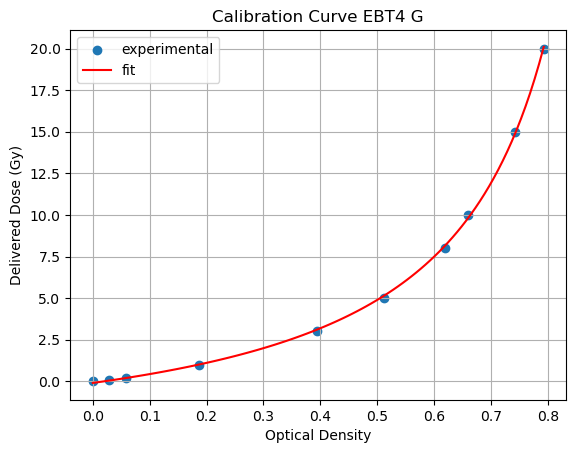

In [48]:
dose_data = np.sort(np.loadtxt(f"calibration/{filmtype}_dose.txt"))

interval = np.linspace(min(OD), max(OD), 100)

def D(x, a, b, c):
    return (a-c*np.exp(-x))/(np.exp(-x)-b)

popt, pcov = curve_fit(D, OD, dose_data, (0, 0, 0), maxfev = 10000)

a, b, c = popt

plt.scatter(OD, dose_data, label='experimental')
plt.plot(interval, D(interval, *popt), label="fit", color="red")
plt.xlabel('Optical Density')
plt.ylabel('Delivered Dose (Gy)')
plt.title(f'Calibration Curve {filmtype} {channel}')
plt.legend()
plt.grid(True)
print(f"\033[1m fit parameters: \033[0m a = {a}, b = {b}, c = {c}")
plt.show()